In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Munging

### assumes data directory as ./static_dataset/{video_id}/{non_}static/*.jpg

In [2]:
import os
import glob
import re
import json
import h5py
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

def sort_video_urls(video_dir):
    re_meta = re.compile(r'(?<=\/)[0-9]+\.[0-9]+(?=\.)')

    df = pd.DataFrame([
            tuple([int(x) for x in re_meta.search(x).group().split('.')]+[x])
            for x in glob.glob(video_dir+'/*')
        ], columns=['frame', 'face', 'url']
    )
    
    url_lists = {
        face:df[df.face==face].sort_values(by='frame').url.tolist()
        for face in sorted(df.face.unique())
    }
    return url_lists

def make_video_array(url_list):
    dims = (380, 380, 3)
    shapes = set()
    video = np.empty((len(url_list), *dims)).astype(np.uint8)
    for i,path in enumerate(url_list):
        frame = cv2.imread(path)
        shapes.add(frame.shape)
        frame = cv2.resize(frame, (dims[0], dims[1]))
        video[i] = frame
    return video, shapes

def convert_to_h5(data_dir):
    video_dirs = glob.glob(os.path.join(data_dir, *'**'))
    re_labels = re.compile(r'(?<=[^0-9])[0-9]+\/.{0,4}static$')
    
    shapes_all = set()
    face_id = 0
    
    with h5py.File(os.path.join(data_dir, 'data.h5'), 'w') as f:
        for video_dir in tqdm(video_dirs):
            vid_id, label = re_labels.search(video_dir).group().split('/')
            urls = sort_video_urls(video_dir)

            for face, (video, shapes) in zip(urls.keys(), map(make_video_array, urls.values())):
                shapes_all.update(shapes)
                d = f.create_dataset(str(face_id).zfill(5), data=video)
                d.attrs['vid_id'] = vid_id
                d.attrs['face_id'] = face
                d.attrs['label'] = 0 if label=='non_static' else 1
                
                face_id+=1
    print('unique shapes:', shapes)

In [ ]:
data_dir = './static_dataset'

In [3]:
# convert_to_h5(data_dir)

# with open('static_dataset/metadata.json', 'r') as f:
#     meta = json.load(f)
# meta

# Convolutional Features

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from src.data_utils import VideoDataset
from src.spatial_transforms import (Compose, Normalize, Scale, ToTensor)
from src.temporal_transforms import LoopPadding

sample_duration=16
mean, std = [0.43216, 0.394666, 0.37645], [0.22803, 0.22145, 0.216989]

spatial_transform = Compose([Scale(224), ToTensor(), Normalize(mean, std)])
temporal_transform = LoopPadding(16)

In [43]:
import torchvision

class ResNetSimple(nn.Module):
    def __init__(self):
        super(ResNetSimple, self).__init__()
        self.base = torchvision.models.video.r2plus1d_18(pretrained=False)
        self.proj = nn.Linear(400, 2)
        
    def forward(self, uid, video, label):
        out = self.base(video)
        out = self.proj(out)
        return out

In [45]:
model = ResNetSimple()
dataset = VideoDataset(
    os.path.join(data_dir, 'data.h5'), 
    sample_duration=sample_duration,
    spatial_transform=spatial_transform, 
    temporal_transform=temporal_transform
)

In [46]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
batch = next(iter(dataloader))

In [48]:
model(**batch)

tensor([[-0.0545,  0.0477],
        [ 0.0014, -0.0031]], grad_fn=<AddmmBackward>)

In [9]:
batch['video'].shape

torch.Size([2, 3, 16, 224, 224])

In [10]:
model(batch['video']).shape

torch.Size([2, 400])

# Optical Flow Features

In [49]:
with h5py.File(os.path.join(data_dir, 'data.h5'), 'r') as f:
    testvid = f['00000'][:]

In [50]:
def compute_optical_flow(frames):
    flow_array = np.empty(frames.shape).astype(np.uint8)
    first_frame = frames[0]
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY) 
    
    mask = np.zeros_like(first_frame) 
    # Sets image saturation to maximum 
    mask[..., 1] = 255
    
    n = 0
    
    for frame in frames:

        # Converts each frame to grayscale - we previously  
        # only converted the first frame to grayscale 
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

        # Calculates dense optical flow by Farneback method 
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0) 

        # Computes the magnitude and angle of the 2D vectors 
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 

        # Sets image hue according to the optical flow  
        # direction 
        mask[..., 0] = angle * 180 / np.pi / 2

        # Sets image value according to the optical flow 
        # magnitude (normalized) 
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX) 

        # Converts HSV to RGB (BGR) color representation 
        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR) 
        flow_array[n] = rgb
        n+=1
        # Opens a new window and displays the output frame 

        # Updates previous frame 
        prev_gray = gray 
    return flow_array

import numpy as np
import scipy.stats as stats

def compute_power(image):
    image = np.sum(image, axis=-1)
    h, w = image.shape
    
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2
    
    kfreq = np.fft.fftfreq(h) * w
    kfreq2D = np.meshgrid(kfreq, kfreq)
    
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2).flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, int(h/2)+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes, statistic = "mean", bins = kbins)
    Abins *= 4. * np.pi / 3. * (kbins[1:]**3 - kbins[:-1]**3)
    return kvals, Abins

In [51]:
flows = compute_optical_flow(testvid)

Text(0.5, 0, '$k$')

Text(0, 0.5, '$P(k)$')

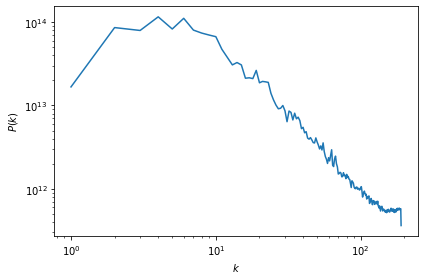

In [52]:
import pylab as pl

pl.loglog(*compute_power(flows[15]))
pl.xlabel("$k$")
pl.ylabel("$P(k)$")
pl.tight_layout()
pl.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")

In [53]:
from PIL import Image

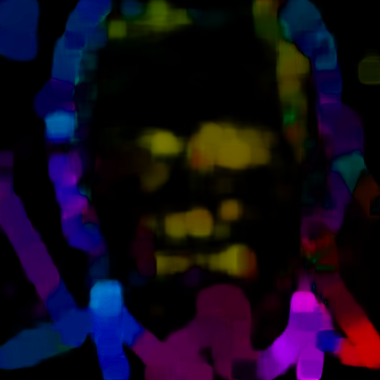

In [54]:
Image.fromarray(flows[15])

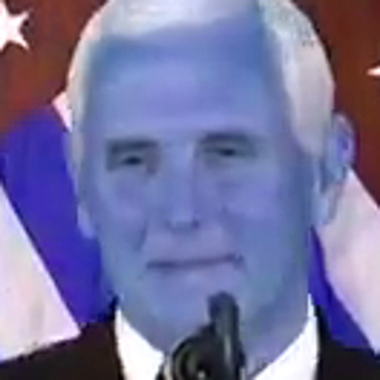

In [55]:
Image.fromarray(testvid[15])